In [81]:
import argparse
import os
import sys
import numpy as np
import torch
from tqdm import tqdm
from dataclasses import dataclass, field
from typing import List, Tuple, Dict

# Huggingface
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration

from yolo.model import Yolo
from yolo.data import (
    CollateWithAnchors,
    CocoDataset,
    get_val_transforms,
    get_train_transforms,
)
from yolo.torchvision_utils import set_weight_decay
from yolo.utils import YoloLoss, DetectionMetrics
from yolo.anchors import DecodeDetections
from yolo.visualize import plot_grid


from safetensors.torch import load_model
from typing import List, Tuple
from PIL import Image

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [3]:
model_checkpoint = "/media/bryan/ssd01/expr/yolo_from_scratch/debug02/checkpoints/checkpoint_9/model.safetensors"

In [4]:
IMAGE_SIZE = 608
ANCHORS = [
    (10,13),
    (16,30),
    (33,23),
    (30,61),
    (62,45),
    (59,119),
    (116,90),
    (156,198),
    (373,326)
]
SCALES = [8, 16, 32]
num_anchors_per_scale = 3

val_dataset = CocoDataset(
    dataset_root = "/media/bryan/ssd01/fiftyone/coco-2017",
    split = "validation",
    transform=get_val_transforms(resize_size=IMAGE_SIZE),
)
collate_instance = CollateWithAnchors(
    ANCHORS,
    SCALES,
    IMAGE_SIZE,
    IMAGE_SIZE,
    num_anchors_per_scale=num_anchors_per_scale,
    num_classes=val_dataset.num_classes,
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=10,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
    num_workers=0,
    collate_fn=collate_instance,
)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [5]:
model = Yolo(
    val_dataset.num_classes,
    num_anchors_per_scale,
)
weight_init = model.body.conv1.weight.detach().clone()
load_model(model, model_checkpoint, device="cpu")
weight_ckpt = model.body.conv1.weight.detach().clone()
assert not torch.allclose(weight_init, weight_ckpt)
model.eval()
model.to("cuda");

In [6]:
batch = next(iter(val_dataloader))

In [7]:
batch["class_names"] = [
    [val_dataset.class_names[c] for c in batch["class_idx"][i].tolist()]
    for i in range(len(batch["image"]))]

In [8]:
outputs = model(batch["image"].to("cuda"))

In [68]:
detection_decoder = DecodeDetections(
    ANCHORS,
    SCALES,
    IMAGE_SIZE,
    IMAGE_SIZE,
    class_names = val_dataset.class_names,
    num_anchors_per_scale=num_anchors_per_scale,
    box_min_area = 50
)

In [75]:
preds = detection_decoder(outputs, objectness_threshold=0.5, iou_threshold=0.5)

In [76]:
preds[3]

{'boxes': BoundingBoxes([[207.9947,  86.2349, 397.8579, 274.6210]], format=BoundingBoxFormat.XYXY, canvas_size=(608, 608)),
 'objectness': tensor([0.9840]),
 'class_probs': tensor([0.9998]),
 'scores': tensor([0.9839]),
 'labels': tensor([11]),
 'class_names': ['stop sign']}

In [77]:
batch_flat = [
    {k:v[i] for k,v in batch.items()} 
for i in range(batch["image"].shape[0])]

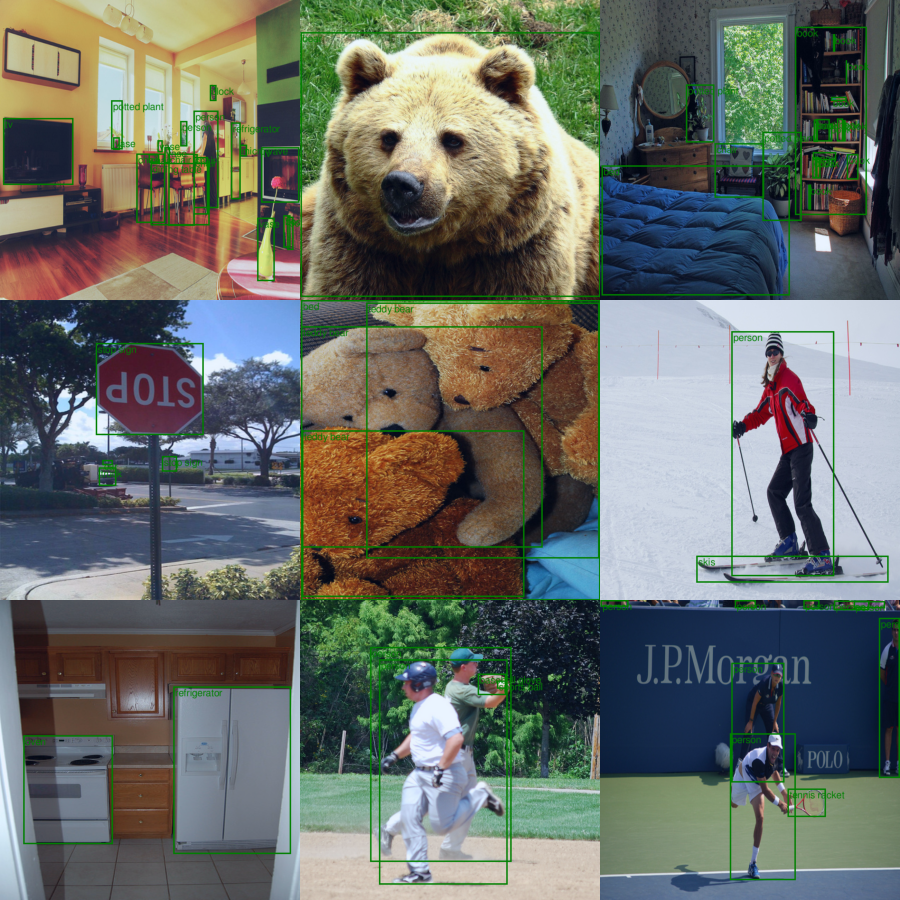

In [78]:
vis = plot_grid(batch_flat, max_images=9, num_cols=3, font_size=20, box_color="green")
Image.fromarray(vis)

In [79]:
for i, image in enumerate(batch["image"]):
    preds[i]["image"] = image

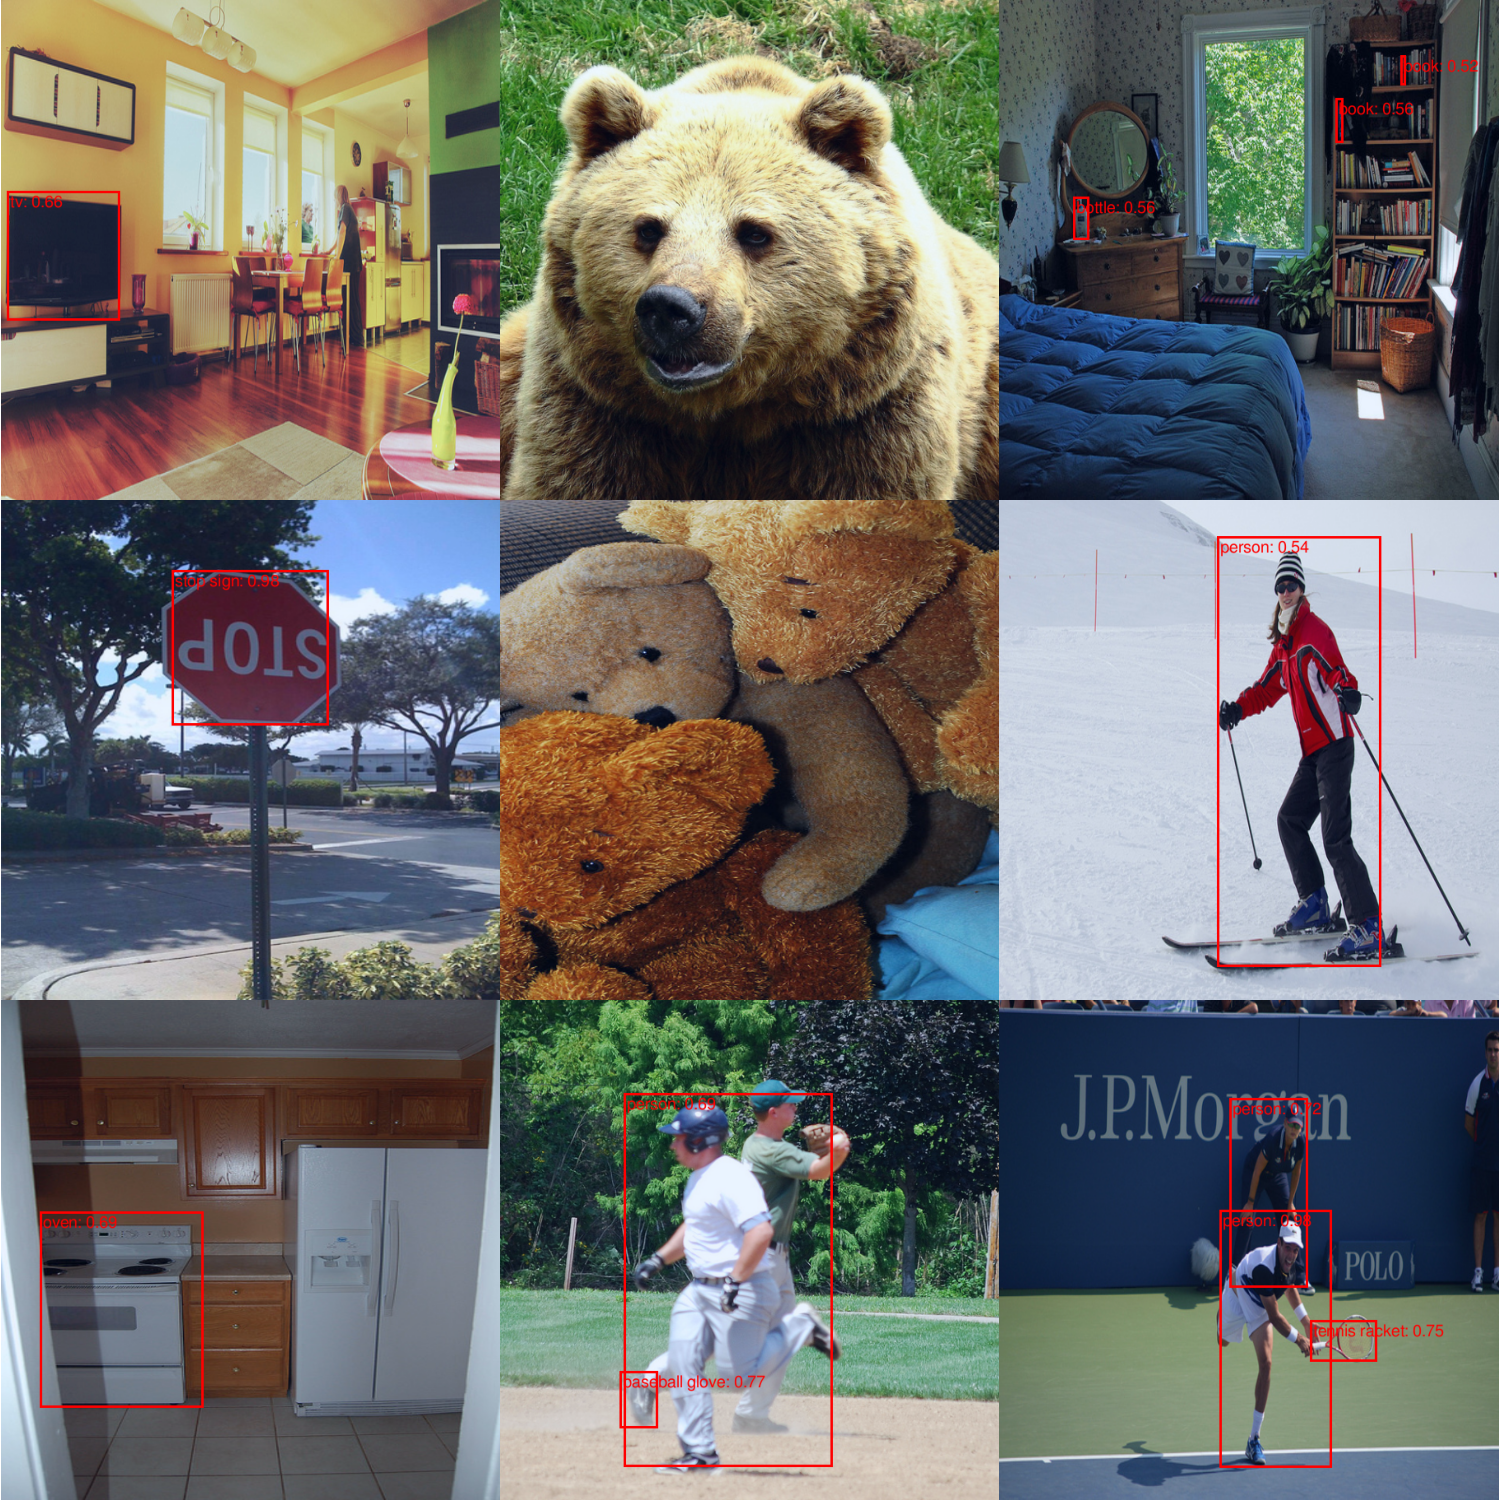

In [80]:
vis = plot_grid(preds, max_images=9, num_cols=3, font_size=20, box_color="red", fig_scaling=5)
Image.fromarray(vis)